In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import truvari
import joblib
import glob
import os
from IPython.display import display, Markdown
import numpy as np

SZBINTY = pd.CategoricalDtype(truvari.SZBINS[1:], ordered=True)
ref_order = ["hg19", "grch38", "chm13"]

In [2]:
metadata = pd.read_csv("../../metadata/sample_metadata.txt", sep="\t")
metadata = metadata.set_index("Individual")

In [3]:
data = joblib.load("../../stats/latest_single_sample_stats.jl")
# Take out extra stuff as needed
redund_samples = ["HG00733", "NA12878", "NA24385"]
pr1 = data["reference"] == 'pr1'
weird = data["merge"] == 'strict.sv'
data = data[~((data["sample"].isin(redund_samples)) & (data["project"] == "eichler")) & ~pr1 & ~weird]

# Average SV count by ancestry for Exact

In [4]:
data['ancestry'] = data['sample'].map(metadata['Superpopulation code'])
data['is_afr'] = data['ancestry'] == 'AFR'
data[data['merge'] == 'exact'].groupby(['sample', 'is_afr', 'reference']).size().reset_index().groupby(['is_afr']).mean()

,0
is_afr,
False,25598.213333
True,30801.000000


# Average SV count by merge / reference

In [5]:
view = data[~data["merge"].str.startswith('removed')].groupby(['merge', 'sample', 'reference']).size().groupby(['reference', 'merge']).mean()
x = view.unstack()
x.loc['mean'] = x.mean()
x['mean'] = x.mean(axis=1)
x

merge,exact,loose,strict,mean
reference,,,,
chm13,25377.361111,23484.388889,24422.888889,24428.212963
grch38,28345.805556,24992.694444,26533.500000,26624.000000
hg19,27840.694444,24533.138889,26048.500000,26140.777778
mean,27187.953704,24336.740741,25668.296296,25730.996914


# Average SV count by reference / SV count

In [6]:
view = data[~data["merge"].str.startswith('removed')].groupby(['merge', 'sample', 'svtype', 'reference']).size().groupby(['reference', 'svtype']).mean()
x = view.unstack()
x

svtype,DEL,INS,DUP,INV,NON,UNK
reference,,,,,,
chm13,11977.407407,12450.805556,0.0,0.0,0.0,0.0
grch38,10105.435185,16518.564815,0.0,0.0,0.0,0.0
hg19,9924.990741,16215.787037,0.0,0.0,0.0,0.0


# Most drastic change

In [7]:
view = data[~data["merge"].str.startswith('removed')].groupby(['merge', 'sample', 'svtype', 'reference']).size().groupby(['reference', 'merge', 'svtype']).mean()
x = view.unstack()
x

svtype                     DEL           INS  DUP  INV  NON  UNK
reference merge                                                 
chm13     exact   12238.305556  13139.055556  0.0  0.0  0.0  0.0
          loose   11632.000000  11852.388889  0.0  0.0  0.0  0.0
          strict  12061.916667  12360.972222  0.0  0.0  0.0  0.0
grch38    exact   10323.638889  18022.166667  0.0  0.0  0.0  0.0
          loose    9830.527778  15162.166667  0.0  0.0  0.0  0.0
          strict  10162.138889  16371.361111  0.0  0.0  0.0  0.0
hg19      exact   10137.305556  17703.388889  0.0  0.0  0.0  0.0
          loose    9656.194444  14876.944444  0.0  0.0  0.0  0.0
          strict   9981.472222  16067.027778  0.0  0.0  0.0  0.0

In [8]:
for i in ['grch38', 'chm13', 'hg19']:
    A = x.loc[i].loc['exact'][["DEL", "INS"]]
    B = x.loc[i].loc['loose'][["DEL", "INS"]]
    increase = (B - A).abs()
    pct_increase = increase / A
    print(i)
    print(pct_increase)

grch38
svtype
DEL    0.047765
INS    0.158693
dtype: float64
chm13
svtype
DEL    0.049542
INS    0.097927
dtype: float64
hg19
svtype
DEL    0.047459
INS    0.159656
dtype: float64


In [9]:
PLOTSON=False
def plot_sv_counts(m_data, base_fn=None):
    """
    Creates a view of the data by reference/sample/project and by svtype with the counts
    Creates a plot, also
    Returns the data view overall and the dataview by svtype
    """
    view = []
    view_bytype = []
    for idx, subdat in m_data.groupby(["reference", "sample", "project"]):
        view.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], len(subdat)])
        subdat["count"] = 1
        tygrp = subdat.groupby(["svtype"]).sum()["count"]
        view_bytype.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], "DEL", tygrp.loc["DEL"]])
        view_bytype.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], "INS", tygrp.loc["INS"]])

    view = pd.DataFrame(view, columns=["reference", "sample", "Superpopulation", "svcount"])
    view_bytype = pd.DataFrame(view_bytype, columns=["reference", "sample", "Superpopulation", "svtype", "svcount"])
    ho = sorted(list(view["Superpopulation"].unique()))
    print(ho)
    if PLOTSON:
        p = sb.catplot(data=view, x="reference", y="svcount", hue="Superpopulation", order=ref_order, hue_order=ho)
        p.legend.remove()
        p.set(title="SV Counts", xlabel="", ylabel="")
        plt.tight_layout()
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Pop.")
        if base_fn:
            ylabels = ['{:,.0f}'.format(x) + 'K' for x in p.ax.get_yticks()/1000]
            p.set_yticklabels(ylabels)
            #plt.xticks(rotation=45)
            plt.savefig(base_fn + "_counts", transparent=True)
        plt.show()
    

        p = sb.catplot(data=view_bytype, x="svtype", y="svcount", hue="Superpopulation", col="reference", col_order=ref_order)
        #p.set(title="SV Counts per-sample by reference/SVTYPE", xlabel="Reference", ylabel="Count")
        p.fig.subplots_adjust(top=0.9) 
        hide = p.fig.suptitle('SV Counts per-sample by reference/SVTYPE')
        if base_fn:
            plt.savefig(base_fn + "_counts_type", transparent=True)
        plt.show()

        with pd.option_context('display.float_format', '{:,.0f}'.format):
            display(view.groupby(["reference"]).describe())

        with pd.option_context('display.float_format', '{:,.0f}'.format):
            display(view_bytype.groupby(["reference", "svtype"]).describe())

    return view, view_bytype
    
def plot_svsize_counts(m_data):
    """
    Creates a view of the data by reference/sample/project and by sizebin with the counts
    Creates a plot, also
    Returns the data view overall and the dataview by svtype
    """
    view = []
    view_bytype = []
    for idx, subdat in m_data.groupby(["reference", "sample", "project"]):
        for size, subdat2 in subdat.groupby("szbin"):
            view.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], size, len(subdat2)])
        for idx2, subdat2 in subdat.groupby(["svtype", "szbin"]):
            svtype, szbin = idx2        
            view_bytype.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], svtype, szbin, len(subdat2)])

    view = pd.DataFrame(view, columns=["reference", "sample", "Superpopulation", "szbin", "svcount"])
    view_bytype = pd.DataFrame(view_bytype, columns=["reference", "sample", "Superpopulation", "svtype", "szbin", "svcount"])
    
    if PLOTSON:
        p = sb.barplot(data=view, x="szbin", y="svcount", order=truvari.SZBINS[1:], hue="reference", hue_order=ref_order)
        p.set(title=f"SV count by SV size")
        plt.xticks(rotation=45, ha="right")
        plt.show()
        p = sb.catplot(data=view_bytype, kind="bar", x="szbin", y="svcount", col="reference", hue="svtype", col_order=ref_order)
        [plt.setp(ax.get_xticklabels(), rotation=45, ha="right") for ax in p.axes.flat]
        p.fig.subplots_adjust(top=0.9) 
        hide = p.fig.suptitle('SV count by SV size/type per-reference')
        plt.show()
        view["szbin"] = view["szbin"].astype(SZBINTY)
        view_bytype["szbin"] = view_bytype["szbin"].astype(SZBINTY)

        with pd.option_context('display.float_format', '{:,.0f}'.format):
            display(view.groupby(["reference", "szbin"]).describe())
            display(view_bytype.groupby(["reference", "svtype", "szbin"]).describe())

    return view, view_bytype

def plot_hethom_stats(m_data):
    """
    Creates a view of the data by reference/sample/project and summarizes the GT counts and ratios
    Creates a plot, also
    Return the data view
    """
    view = []
    for idx, subdat in m_data.groupby(["reference", "sample", "project"]):
        subdat["count"] = 1
        gtgrp = subdat.groupby(["GT"]).sum()["count"]    
        view.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], "TOT", gtgrp.loc["HET"], gtgrp.loc["HOM"]])
        for idx2, subdat2 in subdat.groupby(["svtype"]):
            if idx2 not in ["DEL", "INS"]: continue
            gtgrp = subdat2.groupby(["GT"]).sum()["count"]   
            view.append([idx[0], idx[1], metadata.loc[idx[1]]["Superpopulation code"], idx2, gtgrp.loc["HET"], gtgrp.loc["HOM"]])
    view = pd.DataFrame(view, columns=["reference", "sample", "Superpopulation", "svtype", "HET", "HOM"])
    view["Ratio"] = view["HET"] / view["HOM"]
    if PLOTSON:
        p = sb.catplot(data=view[view["svtype"] == "TOT"], x="reference", y="Ratio", hue="Superpopulation", order=ref_order)
        p.set(title="Het/Hom ratio per-sample by reference", xlabel="Reference", ylabel="Het/Hom Ratio")
        plt.show()

        with pd.option_context('display.float_format', '{:.2f}'.format):
            display(view.groupby(["reference", "svtype"])["Ratio"].describe())
    return view

In [10]:
strict_data = data[(data["merge"] == "strict")]
display(Markdown("# Strict Merging - Per-Sample Stats"))
display(Markdown("## SVCounts per-sample"))
strict_sv_counts = plot_sv_counts(strict_data, "./strict_persample")
display(Markdown("## SVCounts by SZBIN per-sample"))
strict_sz_counts = plot_svsize_counts(strict_data)
display(Markdown("## SV HET/HOM Ratios"))
strict_gt_counts = plot_hethom_stats(strict_data)

# Strict Merging - Per-Sample Stats

## SVCounts per-sample

['AFR', 'AMR', 'EAS', 'EUR', 'SAS']


## SVCounts by SZBIN per-sample

## SV HET/HOM Ratios

Then, we'll look at a comparison of the strategies and what it means for the truth set SV counts by comparing with 'exact' and 'loose' merges

In [11]:
exact_data = data[(data["merge"] == "exact")]
display(Markdown("# Exact Merging - Per-Sample Stats"))
display(Markdown("## SVCounts per-sample"))
exact_sv_counts = plot_sv_counts(exact_data)
display(Markdown("## SVCounts by SZBIN per-sample"))
exact_sz_counts = plot_svsize_counts(exact_data)
display(Markdown("## SV HET/HOM Ratios"))
exact_gt_counts = plot_hethom_stats(exact_data)

# Exact Merging - Per-Sample Stats

## SVCounts per-sample

['AFR', 'AMR', 'EAS', 'EUR', 'SAS']


## SVCounts by SZBIN per-sample

## SV HET/HOM Ratios

In [12]:
loose_data = data[(data["merge"] == "loose")]

display(Markdown("# Loose Merging - Per-Sample Stats"))
display(Markdown("## SVCounts per-sample"))
loose_sv_counts = plot_sv_counts(loose_data)
display(Markdown("## SVCounts by SZBIN per-sample"))
loose_sz_counts = plot_svsize_counts(loose_data)
display(Markdown("## SV HET/HOM Ratios"))
loose_gt_counts = plot_hethom_stats(loose_data)

# Loose Merging - Per-Sample Stats

## SVCounts per-sample

['AFR', 'AMR', 'EAS', 'EUR', 'SAS']


## SVCounts by SZBIN per-sample

## SV HET/HOM Ratios

# Summary figures
Need to take the views and put them together to make a facetgrid so that 
I can show merging strategy's effects for Counts and Het/Hom ratios

In [13]:
exact_sv_counts[0]["merge"] = "exact"
strict_sv_counts[0]["merge"] = "strict"
loose_sv_counts[0]["merge"] = "loose"
sv_counts = pd.concat([exact_sv_counts[0], strict_sv_counts[0], loose_sv_counts[0]])

exact_sv_counts[1]["merge"] = "exact"
strict_sv_counts[1]["merge"] = "strict"
loose_sv_counts[1]["merge"] = "loose"
sv_counts_byty = pd.concat([exact_sv_counts[1], strict_sv_counts[1], loose_sv_counts[1]])

In [14]:
sv_counts_byty.groupby(['reference', 'merge', 'svtype'])['svcount'].mean().reset_index().groupby(['reference', 'svtype']).mean()

svcount
reference svtype              
chm13     DEL     11977.407407
          INS     12450.805556
grch38    DEL     10105.435185
          INS     16518.564815
hg19      DEL      9924.990741
          INS     16215.787037

# Figure 2b

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_22955/1971304559.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["%d" % (x // 1000) for x in range(8000, 22001, 2000)])


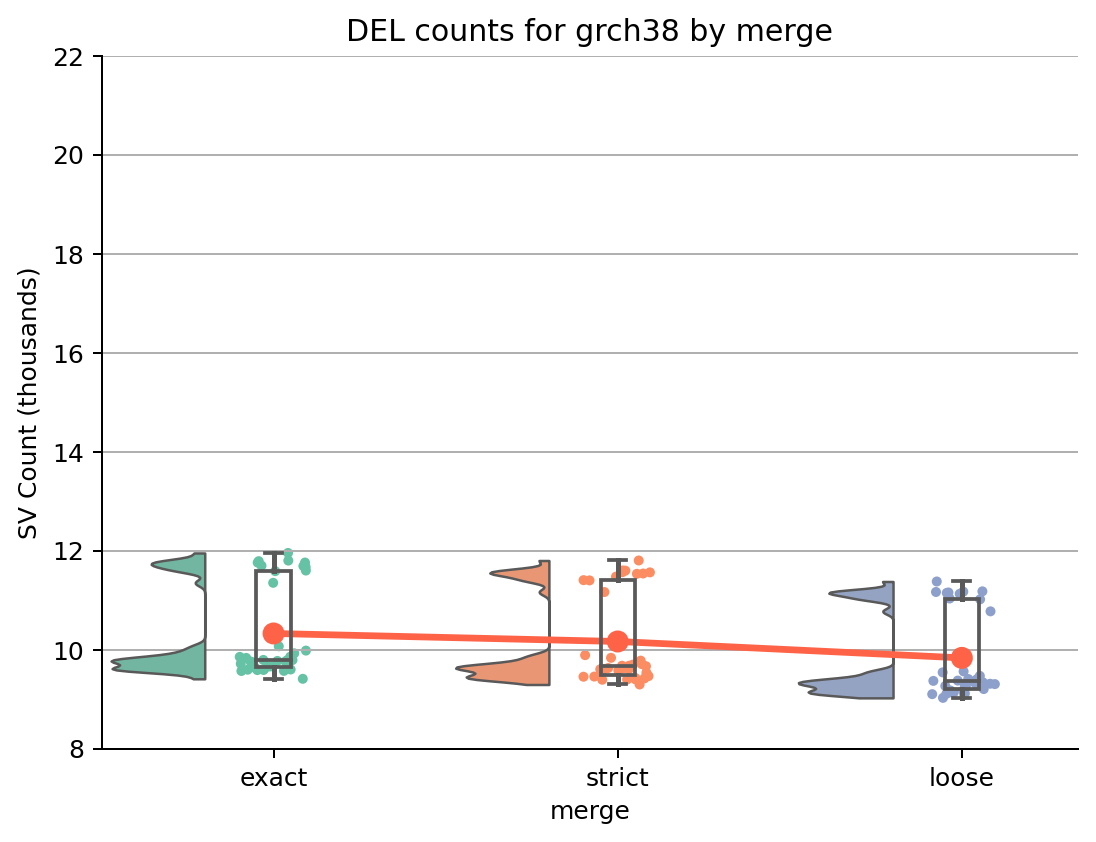

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_22955/1971304559.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["%d" % (x // 1000) for x in range(8000, 22001, 2000)])


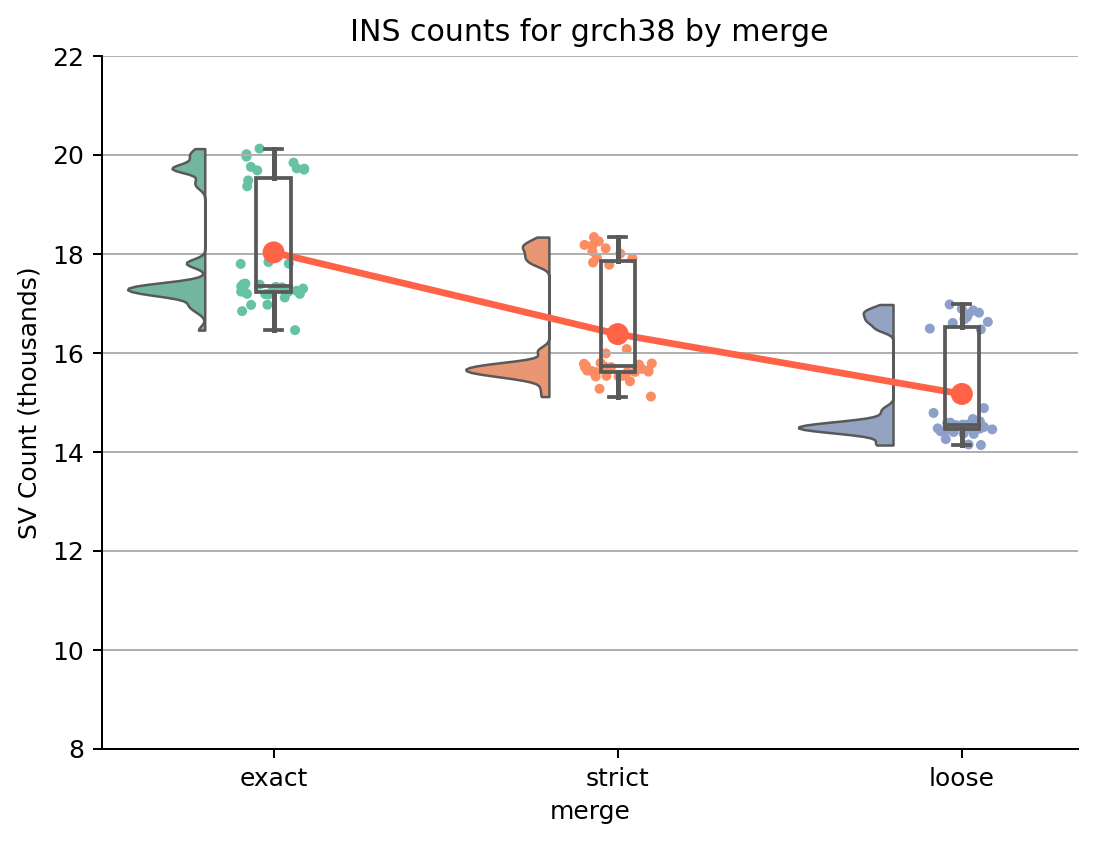

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_22955/1971304559.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["%d" % (x // 1000) for x in range(8000, 22001, 2000)])


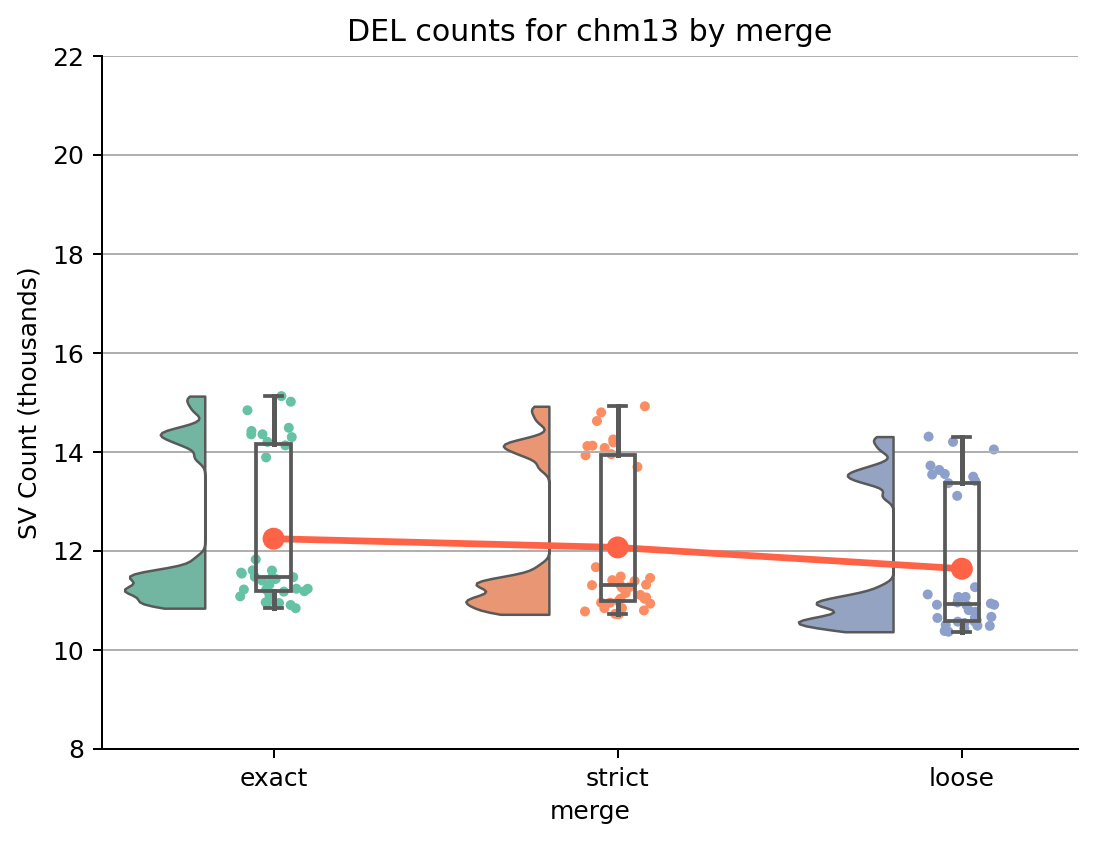

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_22955/1971304559.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["%d" % (x // 1000) for x in range(8000, 22001, 2000)])


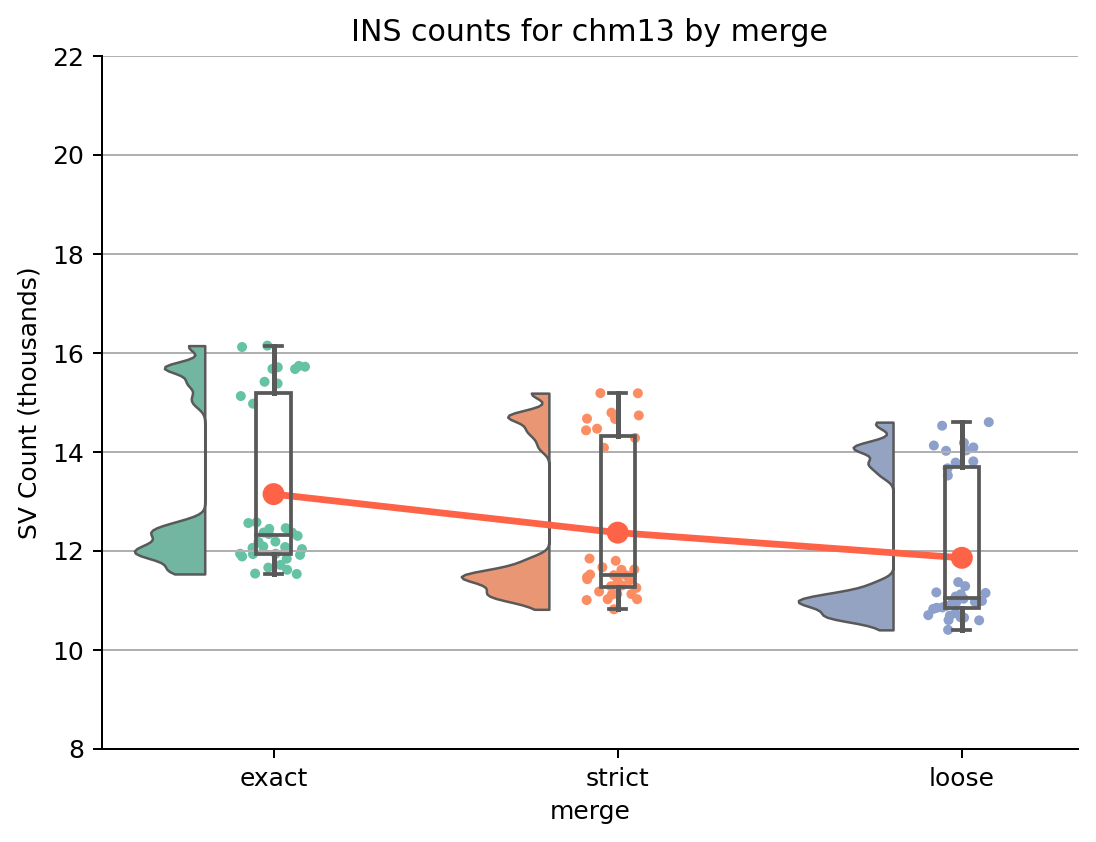

In [15]:
import ptitprince as pt
import matplotlib.pyplot as plt

# Changing orientation
dx="merge"; dy="svcount"; ort="v"; pal = "Set2"; sigma = .07
for ref in ['grch38', 'chm13']:
    for svtype in ['DEL', 'INS']:
        f, ax = plt.subplots(figsize=(7, 5), dpi=180)
        df = sv_counts_byty[(sv_counts_byty["svtype"] == svtype) 
                            & (sv_counts_byty['reference'] == ref)]
        ax=pt.RainCloud(x = dx, y = dy, data = df, palette = pal, bw = sigma,
                         width_viol = .55, width_box=0.10, point_size=4, move=0, jitter=1,
                        ax = ax, orient = ort, pointplot=True, linecolor='tomato')
        plt.title(f"{svtype} counts for {ref} by merge")
        ax.set_ylim(8000, 22000)
        sb.despine()
        plt.grid(which='major', axis='y')
        ax.set_axisbelow(True)
        ax.set_yticklabels(["%d" % (x // 1000) for x in range(8000, 22001, 2000)])
        ax.set_ylabel("SV Count (thousands)")
        plt.show()


/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_22955/2562413076.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["%d" % (x // 1000) for x in range(20000, 32501, 2000)])


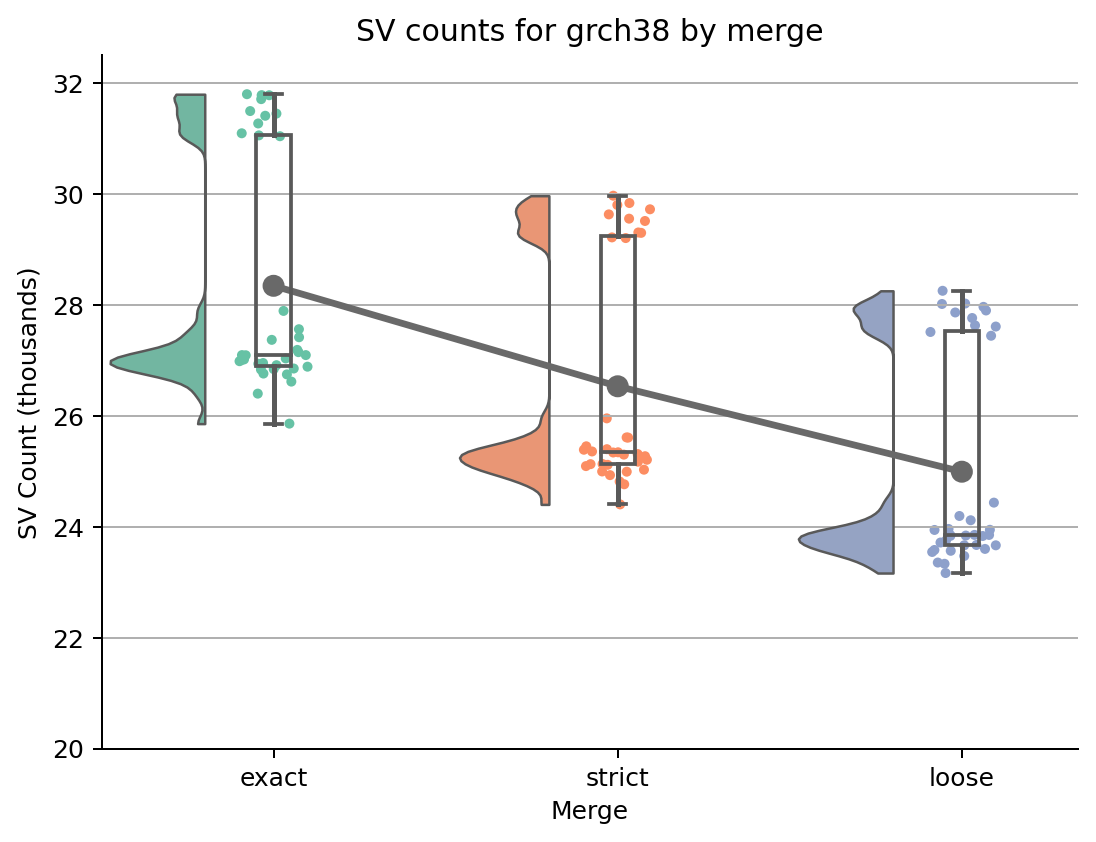

In [34]:
# Changing orientation
sv_counts["Merge"] = sv_counts['merge']
dx="Merge"; dy="svcount"; ort="v"; pal = "Set2"; sigma = .07
for ref in ['grch38']:
    f, ax = plt.subplots(figsize=(7, 5), dpi=180)
    df = sv_counts[sv_counts['reference'] == ref]
    ax=pt.RainCloud(x = dx, y = dy, data = df, palette = pal, bw = sigma,
                     width_viol = .55, width_box=0.10, point_size=4, move=0, jitter=1,
                    ax = ax, orient = ort, pointplot=True, linecolor='dimgray')
    plt.title(f"SV counts for {ref} by merge")
    ax.set_ylim(20000, 32500)
    sb.despine()
    plt.grid(which='major', axis='y')
    ax.set_axisbelow(True)
    ax.set_yticklabels(["%d" % (x // 1000) for x in range(20000, 32501, 2000)])
    ax.set_ylabel("SV Count (thousands)")
    plt.show()

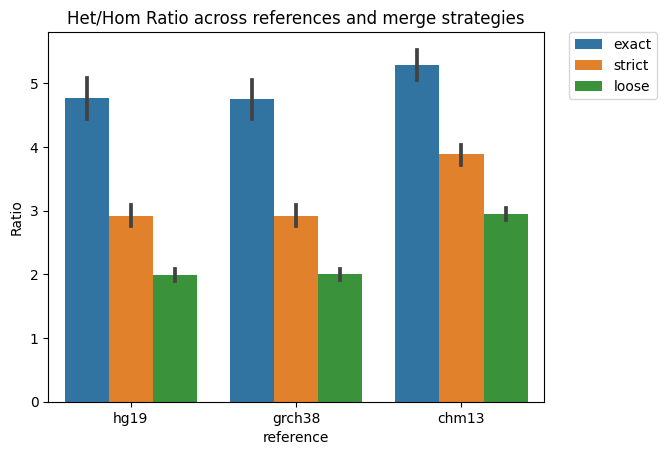

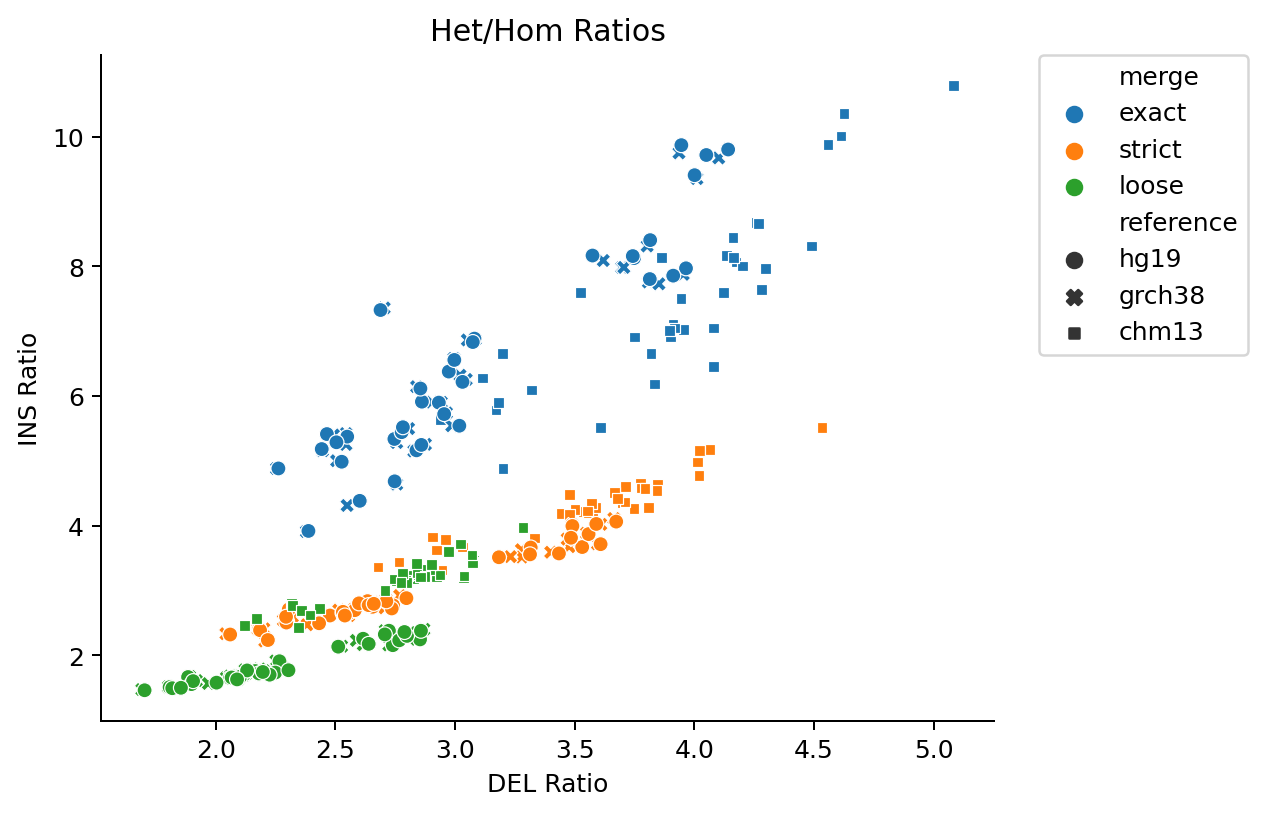

In [17]:
view = []
for name, big_df in [("exact", exact_gt_counts), ("strict", strict_gt_counts), ("loose", loose_gt_counts)]:
    for i, d in big_df.groupby(["reference", "sample", "Superpopulation"]):
        d.set_index("svtype", inplace=True)
        view.append([*i, name, d.loc["DEL"].Ratio, d.loc["INS"].Ratio, d.loc["TOT"].Ratio])
view = pd.DataFrame(view, columns=["reference", 
                                   "sample", 
                                   "Superpopulation", 
                                   "merge", 
                                   "DEL Ratio", 
                                   "INS Ratio", 
                                   "Ratio"])
p = sb.barplot(data=view, x="reference", hue="merge", y="Ratio", order=ref_order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
hide = p.set(title="Het/Hom Ratio across references and merge strategies")
plt.show()
plt.figure(dpi=180)
p = sb.scatterplot(data=view, 
                   x="DEL Ratio", 
                   y="INS Ratio", 
                   hue="merge", 
                   style="reference", 
                   markers=True,
                  style_order=ref_order)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sb.despine()
hide = p.set(title="Het/Hom Ratios")

In [18]:
view.groupby('merge')["Ratio"].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
merge,,,,,,,,
exact,108.0,4.9,0.9,3.2,4.1,4.8,5.7,7.1
loose,108.0,2.3,0.5,1.6,1.8,2.3,2.9,3.6
strict,108.0,3.2,0.7,2.2,2.6,3.2,3.9,5.0


In [19]:
len(data['sample'].unique())

36

# Supplementary

import random
import numpy as np
successes = 0
ppl = 5
trials = 1000000
n_days = 365
for _ in range(trials):
    bdays = []
    for x in range(ppl):
        bdays.append(random.randint(0, n_days))
    days = np.array(bdays)
    early = min(days)
    late = max(days)
    if late - early <= 31:
        successes += 1
print(successes, trials, successes / trials)


In [20]:
def merge_strategy_plots(m_data, m_data_byty, reference="grch38"):
    plt.figure(dpi=180)
    is_ref = m_data["reference"] == reference
    plt.grid(which='major', axis='y')

    p = sb.violinplot(data=m_data[is_ref], x="merge", y="svcount", color='gray')
    p.set_axisbelow('line')
    plt.setp(p.collections, alpha=.3)
    p = sb.swarmplot(data=m_data[is_ref], x="merge", y="svcount", hue="Superpopulation")
    hide = p.set(title=f"SVCounts by Merge Strategy ({reference})", 
                 ylim=(19000, 35000), 
                 ylabel="SV Count (thousands)",
                xlabel="Merge")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Pop. Code")
    p.set_axisbelow(True)

    sb.despine()
    p.set_yticklabels(["%d" % (x // 1000) for x in range(19000, 35001, 2000)])
    plt.show()
    print(help(p.set_axisbelow))
    #p = sb.violinplot(data=m_data_byty[m_data_byty["reference"] == reference], x="merge", y="svcount", hue="svtype")
    #hide = p.set(title=f"SVCounts by Merge ({reference})", ylim=(7000, 22000), xlabel="", ylabel="")
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="svtype")
    #ylabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_yticks()/1000]
    #p.set_yticklabels(ylabels)
    #plt.show()
    

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_22955/2994686098.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(["%d" % (x // 1000) for x in range(19000, 35001, 2000)])


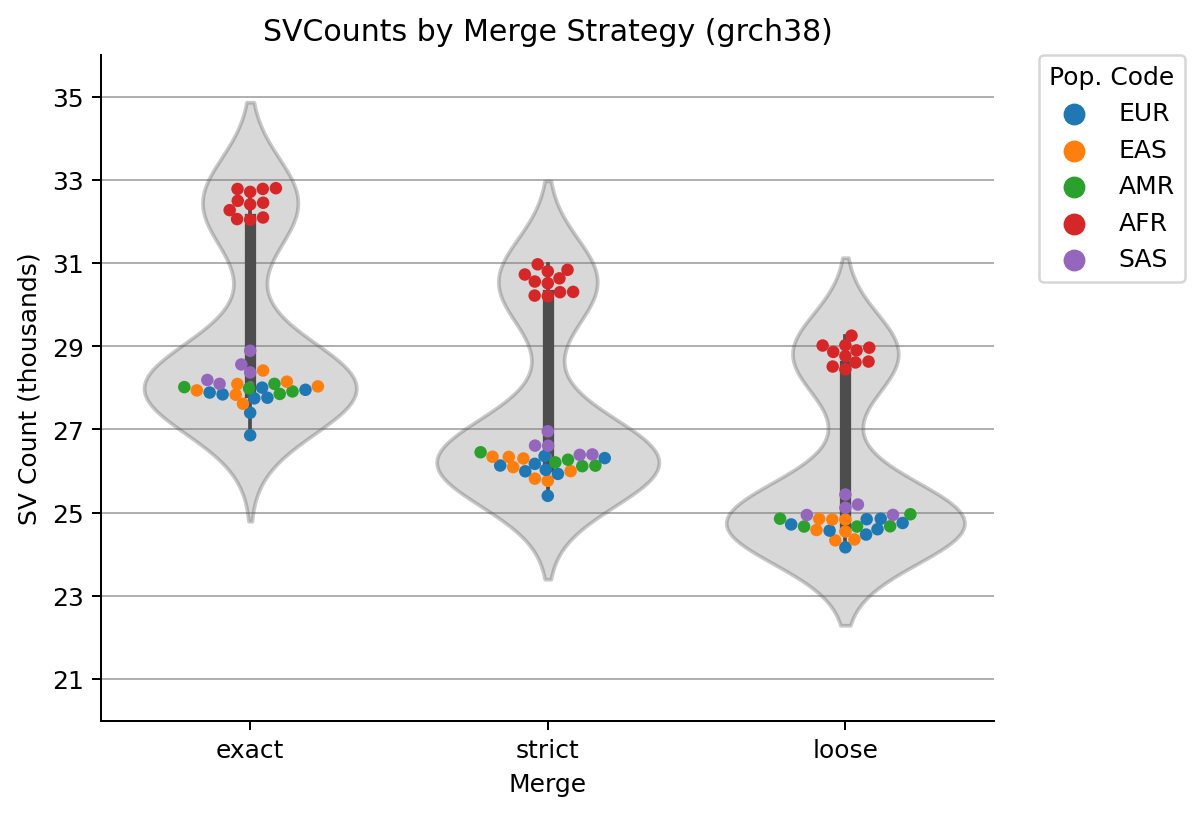

Help on method set_axisbelow in module matplotlib.axes._base:

set_axisbelow(b) method of matplotlib.axes._subplots.AxesSubplot instance
    Set whether axis ticks and gridlines are above or below most artists.
    
    This controls the zorder of the ticks and gridlines. For more
    information on the zorder see :doc:`/gallery/misc/zorder_demo`.
    
    Parameters
    ----------
    b : bool or 'line'
        Possible values:
    
        - *True* (zorder = 0.5): Ticks and gridlines are below all Artists.
        - 'line' (zorder = 1.5): Ticks and gridlines are above patches
          (e.g. rectangles, with default zorder = 1) but still below lines
          and markers (with their default zorder = 2).
        - *False* (zorder = 2.5): Ticks and gridlines are above patches
          and lines / markers.
    
    See Also
    --------
    get_axisbelow

None


/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_22955/2994686098.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(["%d" % (x // 1000) for x in range(19000, 35001, 2000)])


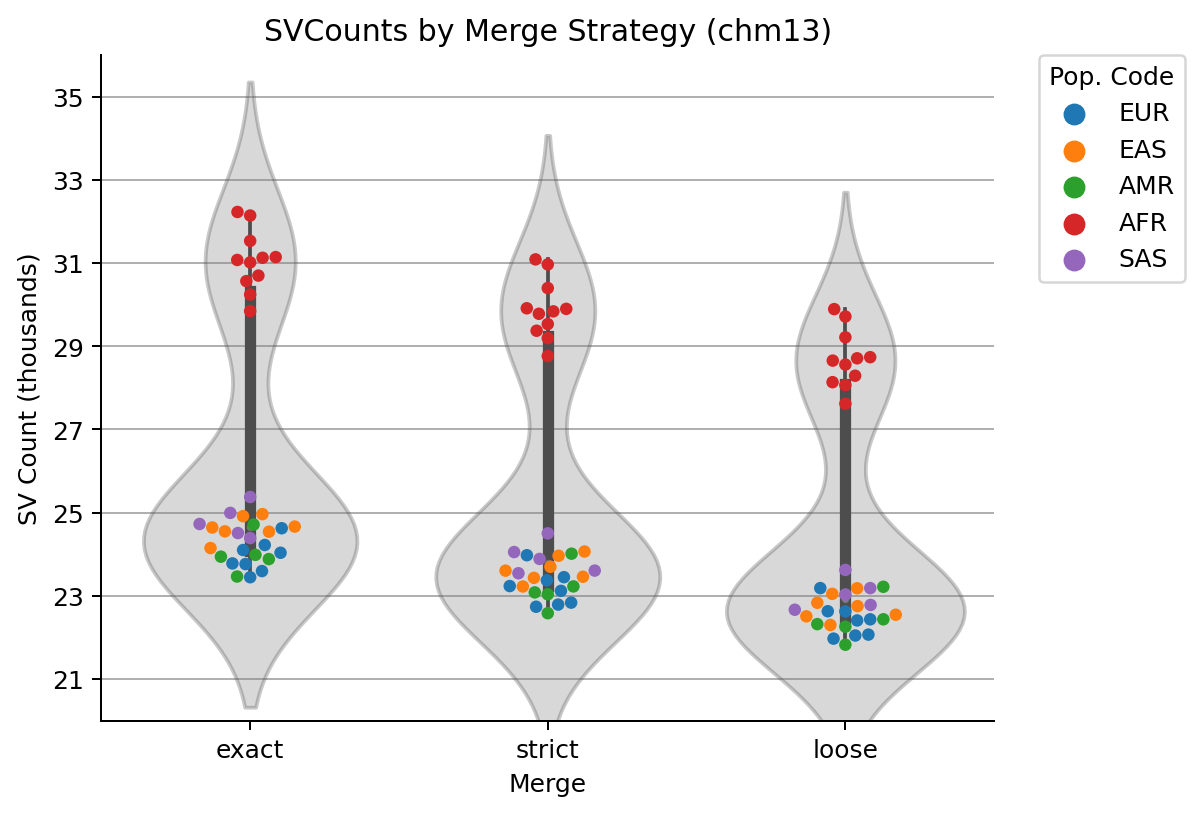

Help on method set_axisbelow in module matplotlib.axes._base:

set_axisbelow(b) method of matplotlib.axes._subplots.AxesSubplot instance
    Set whether axis ticks and gridlines are above or below most artists.
    
    This controls the zorder of the ticks and gridlines. For more
    information on the zorder see :doc:`/gallery/misc/zorder_demo`.
    
    Parameters
    ----------
    b : bool or 'line'
        Possible values:
    
        - *True* (zorder = 0.5): Ticks and gridlines are below all Artists.
        - 'line' (zorder = 1.5): Ticks and gridlines are above patches
          (e.g. rectangles, with default zorder = 1) but still below lines
          and markers (with their default zorder = 2).
        - *False* (zorder = 2.5): Ticks and gridlines are above patches
          and lines / markers.
    
    See Also
    --------
    get_axisbelow

None


In [21]:
#merge_strategy_plots(sv_counts, sv_counts_byty, "hg19")
merge_strategy_plots(sv_counts, sv_counts_byty, "grch38")
merge_strategy_plots(sv_counts, sv_counts_byty, "chm13")
#merge_strategy_plots(sv_counts, sv_counts_byty, "pr1")


# Scratch

In [22]:
view["isAFR"] = view["Superpopulation"] == "AFR"

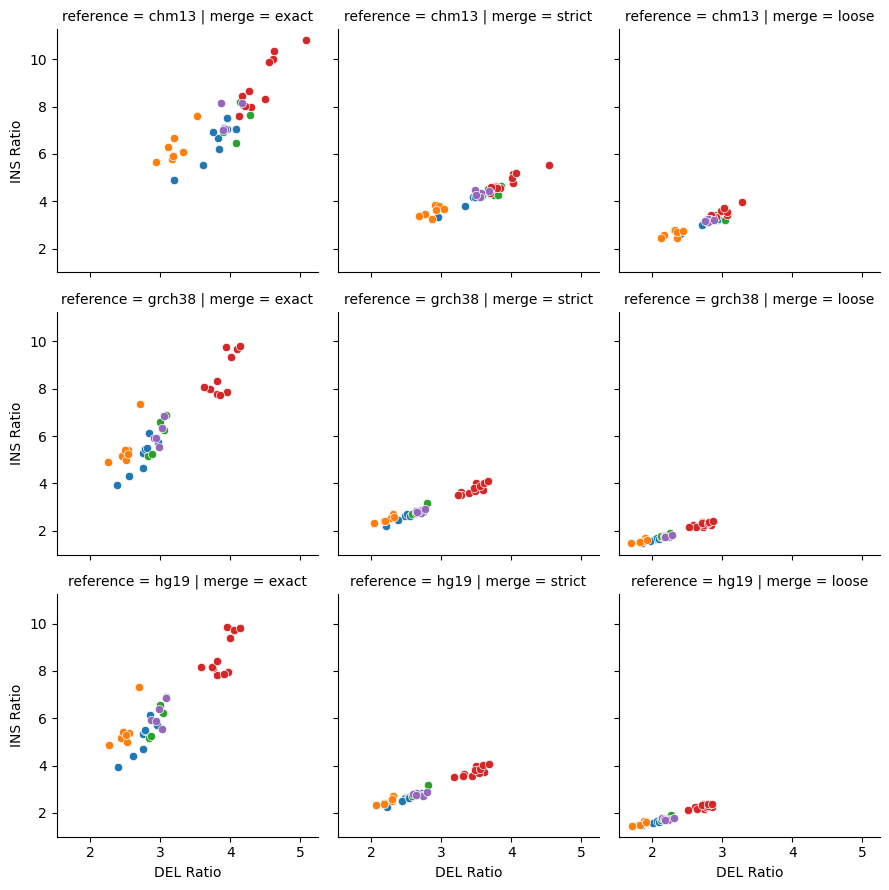

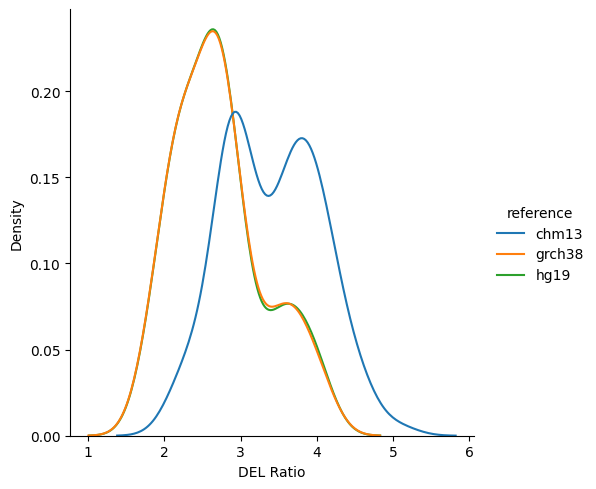

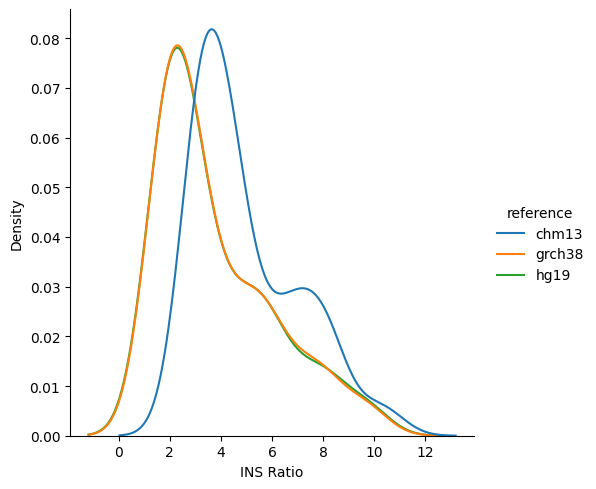

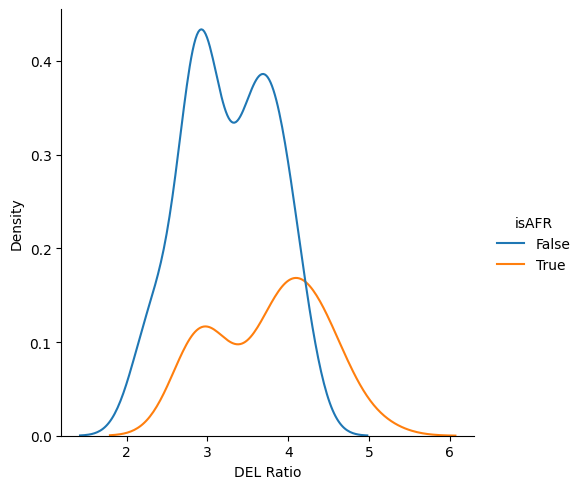

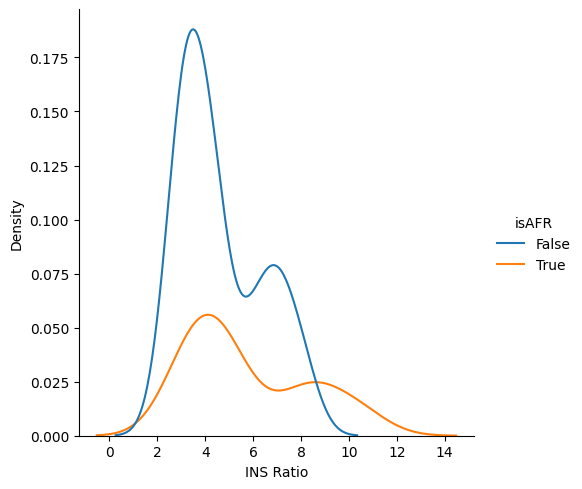

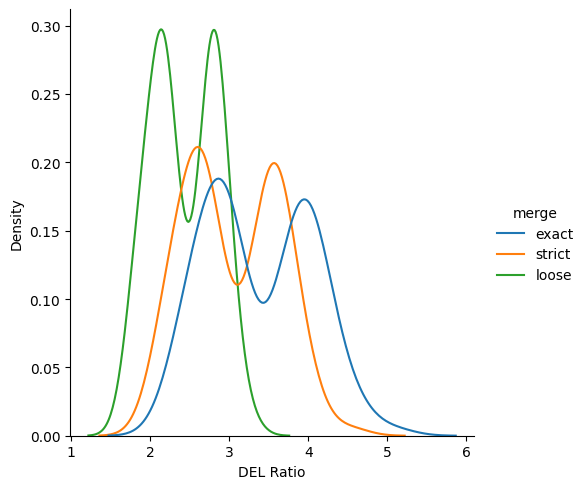

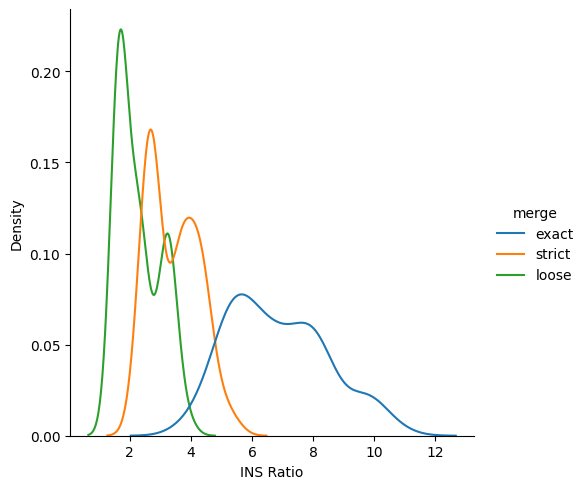

In [23]:
f = sb.FacetGrid(view, row="reference", col="merge", hue="Superpopulation")
f.map(sb.scatterplot, "DEL Ratio", "INS Ratio")
plt.show()
sb.displot(data=view, x="DEL Ratio", hue="reference", kind="kde")
plt.show()
sb.displot(data=view, x="INS Ratio", hue="reference", kind="kde")
plt.show()
sb.displot(data=view[view["reference"] == 'chm13'], x="DEL Ratio", hue="isAFR", kind="kde")
plt.show()
sb.displot(data=view[view["reference"] == 'chm13'], x="INS Ratio", hue="isAFR", kind="kde")
plt.show()
sb.displot(data=view, x="DEL Ratio", hue="merge", kind="kde")
plt.show()
sb.displot(data=view, x="INS Ratio", hue="merge", kind="kde")
plt.show()

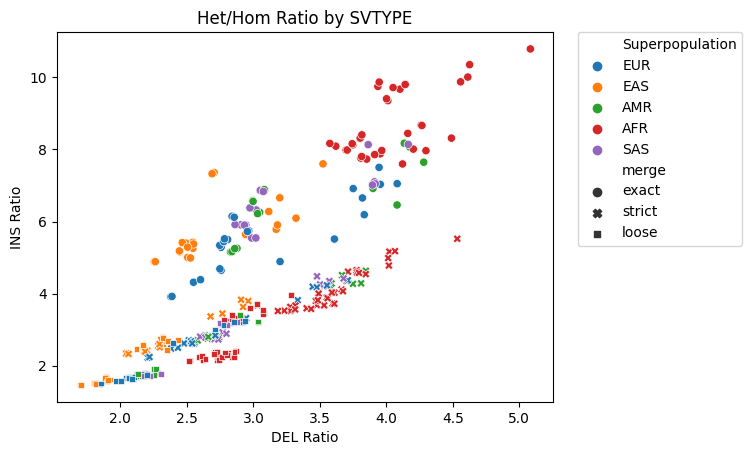

In [24]:
p = sb.scatterplot(data=view, 
                   x="DEL Ratio", 
                   y="INS Ratio", 
                   hue="Superpopulation", 
                   style="merge", 
                   markers=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
hide = p.set(title="Het/Hom Ratio by SVTYPE")

In [25]:
view.groupby(["reference", "merge"]).mean().applymap("{0:.2f}".format).T

reference chm13              grch38               hg19             
merge     exact loose strict  exact loose strict exact loose strict
DEL Ratio  3.93  2.77   3.54   3.10  2.26   2.79  3.10  2.26   2.80
INS Ratio  7.48  3.16   4.28   6.51  1.85   3.01  6.54  1.85   3.00
Ratio      5.29  2.95   3.89   4.75  2.00   2.92  4.76  2.00   2.92
isAFR      0.31  0.31   0.31   0.31  0.31   0.31  0.31  0.31   0.31

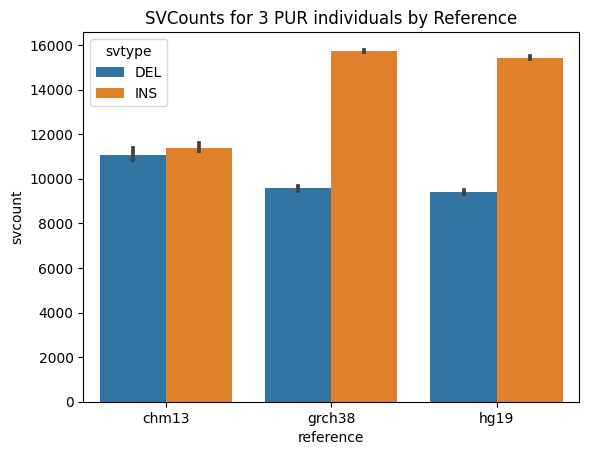

In [26]:
use_type = 1
a = strict_sv_counts[use_type].copy()
a["Population"] = metadata.loc[strict_sv_counts[use_type]["sample"]]["Population code"].reset_index(drop=True)
p = sb.barplot(data=a[a["Population"] == "PUR"], x="reference", y="svcount", hue="svtype")
hide = p.set(title="SVCounts for 3 PUR individuals by Reference")

In [27]:
import joblib
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

data = joblib.load("../../temp/hg002_haps_sim.jl")
data = data[data["state"].isin(["tp", "fp", "fn"])]

data["Similarity"] = "< 70%"
data.loc[(data["PctSeqSimilarity"] >= 0.95) & (data["PctSizeSimilarity"] >= 0.95), \
         "Similarity"] = ">= 95%"


data.loc[(data["PctSeqSimilarity"].between(0.70, 0.95, inclusive='left')) \
         & (data["PctSizeSimilarity"].between(0.70, 0.95, inclusive='left')),
         "Similarity"] = "[70%,95%)"

h_order = [">= 95%", "[70%,95%)", "< 70%"]

# We'll put TruScore on a 0 to 1 Scale so that our diagonal histogram have comparable bins
data["TruScore_"] = data["TruScore"] / 100

data["Top"] = None
data.loc[data['Similarity'] == '< 70%', 'Top'] = 1
data.loc[data['Similarity'] == '[70%,95%)', 'Top'] = 2
data.loc[data['Similarity'] == '>= 95%', 'Top'] = 3
data = data.sort_values(by=['Top'], ascending=True) 

print(data["Similarity"].value_counts())

# These metrics we wish to plot
metrics = ["PctSeqSimilarity", "PctSizeSimilarity", "PctRecOverlap"]#, "TruScore_"]
i = sb.color_palette("Set2")
i.append(i.pop(0))
# Make plot
g = sb.PairGrid(data=data.reset_index(), 
                vars=metrics, hue="Similarity", hue_order=h_order, palette=i[:3])
g.map_diag(sb.histplot, binwidth=0.05, multiple='stack')
g.map_offdiag(sb.scatterplot)#, alpha=0.2)
g.add_legend()
plt.suptitle('NA24385 Haplotype SV Comparison',  y=1.01, 
             size = 24);
plt.show()

plt.figure(dpi=180)
p = sb.scatterplot(data=data.reset_index(), 
                   x="TruScore", 
                   y="PctSeqSimilarity", 
                   hue="Similarity", 
                   style="svtype",
                   style_order=["DEL", "INS"])
p.set(title="Fig3B")
sb.move_legend(p, "upper left", bbox_to_anchor=(1, 1))

FileNotFoundError: [Errno 2] No such file or directory: '../../temp/hg002_haps_sim.jl'

In [ ]:
data[data["PctRecOverlap"] <= 0.05]["Similarity"].value_counts()